<h1 align="center"> Market Prediction based on News Headlines <h1>

## Data Descriptions:

There are two channels of data provided in this dataset:

News data: I crawled historical news headlines from Reddit WorldNews Channel. They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)

Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

## Objectives:

The objective of this notebook is to build a binary classifier that returns 0 (down) or 1 (up). Specifically, 1 means an increase in Adj Close value and 0 means a decrease. Given a set of text data, i.e. news headlines, I will apply natural language processing to extract features. The final performance is 

- Accuracy: 56%
- Precision: 53%
- Recall: 70%

## Table of Contents:

1. **Introduction**<br><br>

2. **Data Cleaning** <br>
a) News Headlines <br>
b) Stock Market Data<br>
c) Tokenization<br>
d) Sparcity of Vectors<br><br>

4. **Predictive Modeling**<br>
a) Counter Vectorization<br>
b) Two-Gram Vectorization<br>
c) TF-IDF<br><br>

5. **Evaluation**

<br>
<br>
## Introduction

- **objective**: <br>
I will focus on showing various kinds of vectorization, stemming and predictive algorithms rather than a performance number. This notebook will give a good sense about my text data wrangling skills.

In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Iteration
import tqdm

# Text Feature Engineering
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from xgboost import clf_rf = grid_search.best_estimator_
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from collections import Counter

%matplotlib inline

In [2]:
news = pd.read_csv("RedditNews.csv", parse_dates=['Date'])
stock = pd.read_csv("DJIA_table.csv", parse_dates=['Date'])

print("news data shape: ", news.shape)
print("stock data shape: ", stock.shape)

news data shape:  (73608, 2)
stock data shape:  (1989, 7)


In [11]:
news.head()

,Date,News
73607,2008-06-08,"b'Marriage, they said, was reduced to the stat..."
73583,2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
73584,2008-06-08,"b""Canada: Beware slippery slope' to censorship..."
73585,2008-06-08,b'EU Vice-President Luisa Morgantini and the I...
73586,2008-06-08,"b""Israeli minister: Israel will attack Iran if..."


In [12]:
stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close,up_or_down,news_1,news_2,...,news_16,news_17,news_18,news_19,news_20,news_21,news_22,news_23,news_24,news_25
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash',"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,"No Help for Mexico's Kidnapping Surge"""
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',...,Israel and the US behind the Georgian aggressi...,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0,Remember that adorable 9-year-old who sang at ...,"Russia 'ends Georgia operation'""",...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right',"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,...,Elephants extinct by 2020?',US humanitarian missions soon in Georgia - if ...,"Georgia's DDOS came from US sources""","Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice',Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,...,Bank analyst forecast Georgian crisis 2 days e...,Georgia confict could set back Russia's US rel...,War in the Caucasus is as much the product of ...,"""Non-media"" photos of South Ossetia/Georgia co...",Georgian TV reporter shot by Russian sniper du...,Saudi Arabia: Mother moves to block child marr...,Taliban wages war on humanitarian aid workers',"Russia: World ""can forget about"" Georgia\'s t...",Darfur rebels accuse Sudan of mounting major a...,Philippines : Peace Advocate say Muslims need ...


In [13]:
print("news range:  {} ~ {}".format(news['Date'].dt.date.min(), news['Date'].dt.date.max()))
print("stock range: {} ~ {}".format(stock['Date'].dt.date.min(), stock['Date'].dt.date.max()))

news range:  2008-06-08 ~ 2016-07-01
stock range: 2008-08-08 ~ 2016-06-30


In [15]:
def isSubSet(date1, date2):
    for date in date1['Date'].dt.date.unique():
        unique_date = date2['Date'].dt.date.unique()
        how_many_missing = 0

        if date not in unique_date:
            how_many_missing += 1
            
    return how_many_missing
        
print("There are {} dates for stock data when no news headline exists".format(isSubSet(stock, news)))
print("There are {} dates for news data when no stock price exists".format(isSubSet(news, stock)))

There are 0 dates for stock data when no news headline exists
There are 1 dates for news data when no stock price exists


These datasets have two different natures. First, it is a time series data with numeric values. Predictive models will be constructed to forecast the numeric values, i.e. stock prices. Second, the data contains extremely unorganized text data points. Again, the news headlines are listed over time. I will first clean up the text data for further analysis. 

<br>
<br>
## Data Cleaning

### Stock:

Drop redundant columns and create a new feature. 'up_or_down' will be a binary label.

In [21]:
# Sort
stock.sort_values(by='Date', axis=0, inplace=True)

# Binary labels
stock['up_or_down'] = (stock['Adj Close'].diff() > 0).astype('int')

# Drop the first row where no previous date exists
stock.drop(0, axis=0, inplace=True)

stock.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close,up_or_down,news_1,news_2,...,news_16,news_17,news_18,news_19,news_20,news_21,news_22,news_23,news_24,news_25
1988,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash',"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,"No Help for Mexico's Kidnapping Surge"""
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',...,Israel and the US behind the Georgian aggressi...,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0,Remember that adorable 9-year-old who sang at ...,"Russia 'ends Georgia operation'""",...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right',"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...


### News Headlines

News headlines are messy. The lengths are different for each data point. Some dates have a more or less number of headlines than the majority of the others. I will consider all the aspects!

In [22]:
# Group by date
by_date = news.set_index('Date').groupby(pd.Grouper(freq='D'))

# See some dates have 22, 23, 24 or 50 headlines
print("Number of headlines per date:", by_date.size().unique())
print("\n", by_date.size().value_counts())

Number of headlines per date: [25 50  0 24 22 23]

 25    2931
23       5
24       4
0        3
50       2
22       1
dtype: int64


In [23]:
# Sort
news.sort_values(by='Date', axis=0, inplace=True)

# Stock df will store up to 25 news headlines per day
new_cols = list(zip(['news_']*25, range(1,26)))

# Transform a long data form into a wide data form.
for new_col in new_cols:
    stock[new_col[0]+str(new_col[1])] = np.nan

for name, group in by_date:
    col = 1
    for text in group['News']:
        stock.loc[stock['Date'] == name, "news_"+ str(col)] = text[2:]
        col += 1
        if col > 25:
            break

In [24]:
# Drop Variables
col_drops = "Open,High,Low,Close,Volume,Adj Close".split(",")
stock = stock.drop(col_drops, axis=1)

In [25]:
stock.head()

,Date,up_or_down,news_1,news_2,news_3,news_4,news_5,news_6,news_7,news_8,...,news_16,news_17,news_18,news_19,news_20,news_21,news_22,news_23,news_24,news_25
1988,2008-08-08,0,Georgian troops retreat from S. Osettain capit...,The 'enemy combatent' trials are nothing but a...,"Breaking: Georgia invades South Ossetia, Russi...",150 Russian tanks have entered South Ossetia w...,Did the U.S. Prep Georgia for War with Russia?',Russian tanks are moving towards the capital o...,Russia Today: Columns of troops roll into Sout...,BREAKING: Musharraf to be impeached.',...,Caucasus in crisis: Georgia invades South Osse...,"No Help for Mexico's Kidnapping Surge""","Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,"Condoleezza Rice: ""The US would not act to pre...",Al-Qaeda Faces Islamist Backlash',Georgia Invades South Ossetia - if Russia gets...,Did World War III start today?',China tells Bush to stay out of other countrie...,This is a busy day: The European Union has ap...
1987,2008-08-11,1,Russia angered by Israeli military sale to Geo...,"Georgia's move, a mistake of monumental propor...",Welcome To World War IV! Now In High Definition!',An American citizen living in S.Ossetia blames...,What were the Mossad with fraudulent New Zeala...,Russia presses deeper into Georgia; U.S. says ...,Georgian army flees in disarray as Russians ad...,Jewish Georgian minister: Thanks to Israeli tr...,...,Perhaps *the* question about the Georgia - Rus...,Russia has just beaten the United States over...,Israeli Physicians Group Condemns State Torture',War in South Ossetia [PICS]',U.S. ship heads for Arctic to define territory',Riots are still going on in Montreal (Canada) ...,"""Do not believe TV, neither Russian nor Georgi...",Israel and the US behind the Georgian aggressi...,The French Team is Stunned by Phelps and the 4...,China to overtake US as largest manufacturer'
1986,2008-08-12,0,U.S. Beats War Drum as Iran Dumps the Dollar',Remember that adorable 9-year-old who sang at ...,"Russia 'ends Georgia operation'""","""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,...,Christopher King argues that the US and NATO a...,All signs point to the US encouraging Georgia ...,Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',"Gorbachev accuses U.S. of making a ""serious bl...",Why Russias response to Georgia was right',U.S. troops still in Georgia (did you know the...,The 11 Top Party Cities in the World',55 pyramids as large as the Luxor stacked into...,"Russia, Georgia, and NATO: Cold War Two'"
1985,2008-08-13,0,Bush announces Operation Get All Up In Russia'...,92% of CNN readers: Russia's actions in Georgi...,The commander of a Navy air reconnaissance squ...,Russian forces sink Georgian ships ',China has moved 10 *million* quake survivors i...,USA to send fleet into Black Sea to help Georg...,"Britain\'s policy of being tough on drugs is ""...",Israel clears troops who killed Reuters camer...,...,Georgian president says US military will take...,Quarter of Russians blame U.S. for conflict: ...,Gorbachev: We Had No Choice',Israeli defence minister: US against strike on...,Witness: Russian forces head towards Tbilisi i...,"Georgia's DDOS came from US sources""",US humanitarian missions soon in Georgia - if ...,Elephants extinct by 2020?',Why Russias response to Georgia was right',"Russian convoy heads into Georgia, violating t..."
1984,2008-08-14,1,Poland and US agree to missle defense deal. In...,Musharraf expected to resign rather than face...,"Russia exaggerating South Ossetian death toll,...","Will the Russians conquer Tblisi? Bet on it, n...",Rushdie Condemns Random House's Refusal to Pub...,Moscow Made Plans Months Ago to Invade Georgia',Russia exaggerated the death 

In [26]:
# document variable is a list of concatenated headlines of each date. 
document = []
for row in stock.iloc[:, 2:].itertuples():
    document.append(" ".join(str(x) for x in row[1:]))
    
labels = stock['up_or_down'].get_values()

In [27]:
Counter(labels)

Counter({0: 924, 1: 1063})

### Tokenization

In [28]:
# Preprocessing: drop the stopwords and apply stemming
def tokenizer(txt):
    ps = PorterStemmer()
    
    new_txt = ''.join([char.lower() for char in txt if char not in string.punctuation][2:])
    tokens = re.split("\W+", new_txt)
    new_txt = [ps.stem(token) for token in tokens if token not in stopwords.words('English')]
    
    return new_txt
    
# Here are three different vectorization algorithms
cv = CountVectorizer(analyzer=tokenizer)
cv_gram = CountVectorizer(ngram_range=(2,2), analyzer=tokenizer)
tf = TfidfVectorizer(analyzer=tokenizer)

In [29]:
counter_vector = cv.fit_transform(document)
two_gram_vector = cv_gram.fit_transform(document)
tf_vector = tf.fit_transform(document)

### Sparicity of Vectors

When learning from high-dimensional data such as text, it has been empirically
observed that relatively few dimensions are relevant to the predictive task. How can we capitalize on this insight and choose which dimensions are relevant
in an informed and principled manner? Sparse regularizers provide a way to select
relevant dimensions by means of regularization. I will first apply plain machine learning algorithms without any feature engineering. Then it will be meaningful to explore sparse regularization techinques.

**Reference**: <a src="https://www.lti.cs.cmu.edu/sites/default/files/dani_yogatama_sparse_models_of_natural_language_text.pdf"> Dani Yogatama, "Sparse Models of Natural Language Text"</a>

<br>
<br>
## Predictive Modeling

### 1. Counter Vectorization 

In [44]:
def count_more_than_one(vector, min_count=2):
    '''
    this function drop the 
    '''
    more_than_one = []
    for i, val in enumerate(vector.sum(axis=0).tolist()[0]):

        if val >= min_count:
            more_than_one.append(i)
    
    return vector[:, more_than_one]

counter_vector = count_more_than_one(counter_vector)
print(counter_vector.shape)

X_train, X_test, y_train, y_test = train_test_split(counter_vector, labels, test_size=0.2, random_state=True)

(1987, 15797)


In [45]:
def fit_model_then_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    print("accuracy: {}".format(accuracy_score(y_test, pred)))
    print("precision: {}\nrecall: {}".format(precision_recall_fscore_support(y_test, pred)[0][1], 
                                 precision_recall_fscore_support(y_test, pred)[1][1]))
    
    
rf = RandomForestClassifier(n_estimators=100)
fit_model_then_eval(rf, X_train, X_test, y_train, y_test)

accuracy: 0.5150753768844221
precision: 0.5227272727272727
recall: 0.7777777777777778


In [34]:
xg = XGBClassifier()
fit_model_then_eval(xg, X_train, X_test, y_train, y_test)

accuracy: 0.5251256281407035
precision: 0.5333333333333333
recall: 0.6956521739130435


<br>
### 2. two-gram Counter Vectorization

In [43]:
X_train, X_test, y_train, y_test = train_test_split(two_gram_vector, labels, test_size=0.2, random_state=True)

In [236]:
rf = RandomForestClassifier()
fit_model_then_eval(rf, X_train, X_test, y_train, y_test)

accuracy: 0.5201005025125628
precision: 0.5421052631578948
recall: 0.4975845410628019


/Users/jimmy/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [233]:
xg = XGBClassifier()
fit_model_then_eval(xg, X_train, X_test, y_train, y_test)

accuracy: 0.47738693467336685
precision: 0.4982078853046595
recall: 0.6714975845410628


In [212]:
params = {'n_estimators': [10, 30, 100, 200], 'max_depth': [1, 5, None], 'bootstrap': [True, False]}
random_rf = RandomizedSearchCV(RandomForestClassifier(), params, cv=5)
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [10, 30, 100, 200], 'max_depth': [1, 5, None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [ ]:
rf_prob = rf.best_estimator_.predict_proba(X_test)
xg_prob = xg.predict_proba(X_test)

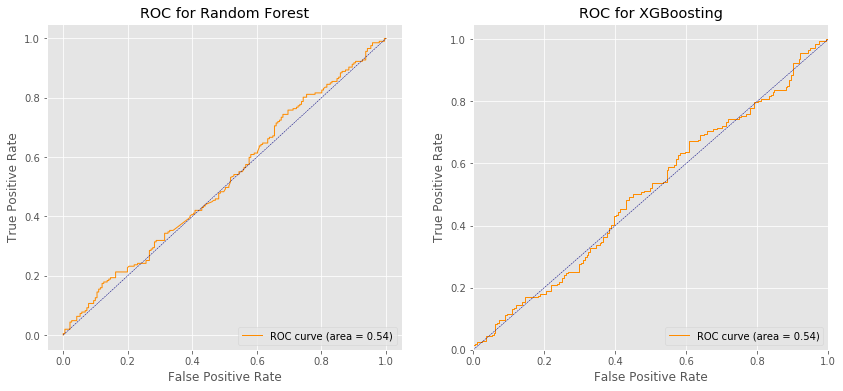

In [239]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_prob[:, 1])
fpr_xg, tpr_xg, thresholds = roc_curve(y_test, xg_prob[:, 1])

auc_rf = auc(fpr, tpr)
auc_xg = auc(fpr, tpr)

plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_rf)
ax1.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC for Random Forest')
ax1.legend(loc="lower right")

ax2.plot(fpr_xg, tpr_xg, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_xg)
ax2.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC for XGBoosting')
ax2.legend(loc="lower right")

plt.show()

In [240]:
model = Sequential()

model.add(layers.Dense(16, input_shape=[X_train.shape[1]] , activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 16)                2784      
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 16)                64        
_________________________________________________________________
dense_137 (Dense)            (None, 16)                272       
_________________________________________________________________
dropout_45 (Dropout)         (None, 16)                0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 16)                64        
_________________________________________________________________
dense_138 (Dense)            (None, 16)                272       
__________

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

callbacks = [ModelCheckpoint('best_nn_h5', monitor='val_acc', save_best_only=True)]

history = model.fit(X_train.toarray(), y_train.reshape(-1, 1), batch_size=16, epochs=100,
                    verbose=2, validation_data=(X_test, y_test), callbacks=callbacks)

<br>
### 3. TF-IDF Vectorization

In [41]:
X_train, X_test, y_train, y_test = train_test_split(tf_vector, labels, test_size=0.2, random_state=True)

In [42]:
rf = RandomForestClassifier(n_estimators=100)
fit_model_then_eval(rf, X_train, X_test, y_train, y_test)

accuracy: 0.5326633165829145
precision: 0.5379061371841155
recall: 0.7198067632850241


In [40]:
xg = XGBClassifier()
fit_model_then_eval(xg, X_train, X_test, y_train, y_test)

accuracy: 0.5226130653266332
precision: 0.532319391634981
recall: 0.6763285024154589


<br>
# Conclusion:

The performance of the models are somehow disappointing. I assume that predicting market movement based on news headlines have too much noise in the data. It might be possible, though, that the performance increase than randome classification given far more dataset.